# Explain how to downsample the behavioural data to the same sampling rate as the neural data <br>
Jonas Braun <br>
jonas.braun@epfl.ch <br>
03.05.2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## load behavioural and neural data

In [2]:
beh_data_dir = "/mnt/labserver/_Teaching/_2102_BIOENG-456_CoBaR/Week8-Intro-mini-project/Data/COBAR_behaviour.pkl"
beh_df = pd.read_pickle(beh_data_dir)

In [3]:
neural_data_dir = "/mnt/labserver/_Teaching/_2102_BIOENG-456_CoBaR/Week8-Intro-mini-project/Data/COBAR_neural.pkl"
neural_df = pd.read_pickle(neural_data_dir)

## define function to resample

In [4]:
# these two functions are just wrappers around the numpy functions to apply them across dimension 0 only
def reduce_mean(values):
    return np.mean(values, axis=0)
def reduce_std(values):
    return np.std(values, axis=0)

def reduce_during_2p_frame(twop_index, values, function=reduce_mean):
    """
    Reduces all values occuring during the acquisition of a
    two-photon imaging frame to a single value using the `function` given by the user.
    Parameters
    ----------
    twop_index : numpy array
        1d array holding frame indices of one trial.
    values : numpy array
        Values upsampled to the frequency of ThorSync,
        i.e. 1D numpy array of the same length as
        `frame_counter` or 2D numpy array of the same length.
    function : function
        Function used to reduce the value,
        e.g. np.mean for 1D variables
    Returns
    -------
    reduced : numpy array
        Numpy array with value for each two-photon imaging frame.
    """
    
    if len(twop_index) != len(values):
        raise ValueError("twop_index and values need to have the same length.")
    if len(values.shape) == 1:
        values = np.expand_dims(values, axis=1)
        squeeze = True
    else:
        squeeze = False
    N_samples, N_variables = values.shape
    
    index_unique = np.unique(twop_index)
    index_unique = np.delete(index_unique, index_unique==-9223372036854775808)
    
    dtype = values.dtype
    if np.issubdtype(dtype, np.number):
        dtype = np.float
    else:
        dtype = np.object
    reduced = np.empty((len(index_unique), N_variables), dtype=dtype)

    for i, index in enumerate(index_unique):
        reduced[i] = function(values[twop_index==index, :])

    return np.squeeze(reduced) if squeeze else reduced

# try out the function for one joint angle in the first trial

In [5]:
twop_index = beh_df.loc[(210301, "J1xCI9", 1, 0), "twop_index"].to_numpy()
# alternative: beh_df[beh_df.index.get_level_values("Trial")==0]["twop_index"].to_numpy()

In [6]:
values = beh_df.loc[(210301, "J1xCI9", 1, 0), "angle_RF_leg_Coxa_yaw"].to_numpy()

In [7]:
reduced = reduce_during_2p_frame(twop_index, values, function=reduce_mean)

## comparing the results <br>
### note how the second plotting command uses the "t" variables of neural_df

<IPython.core.display.Javascript object>


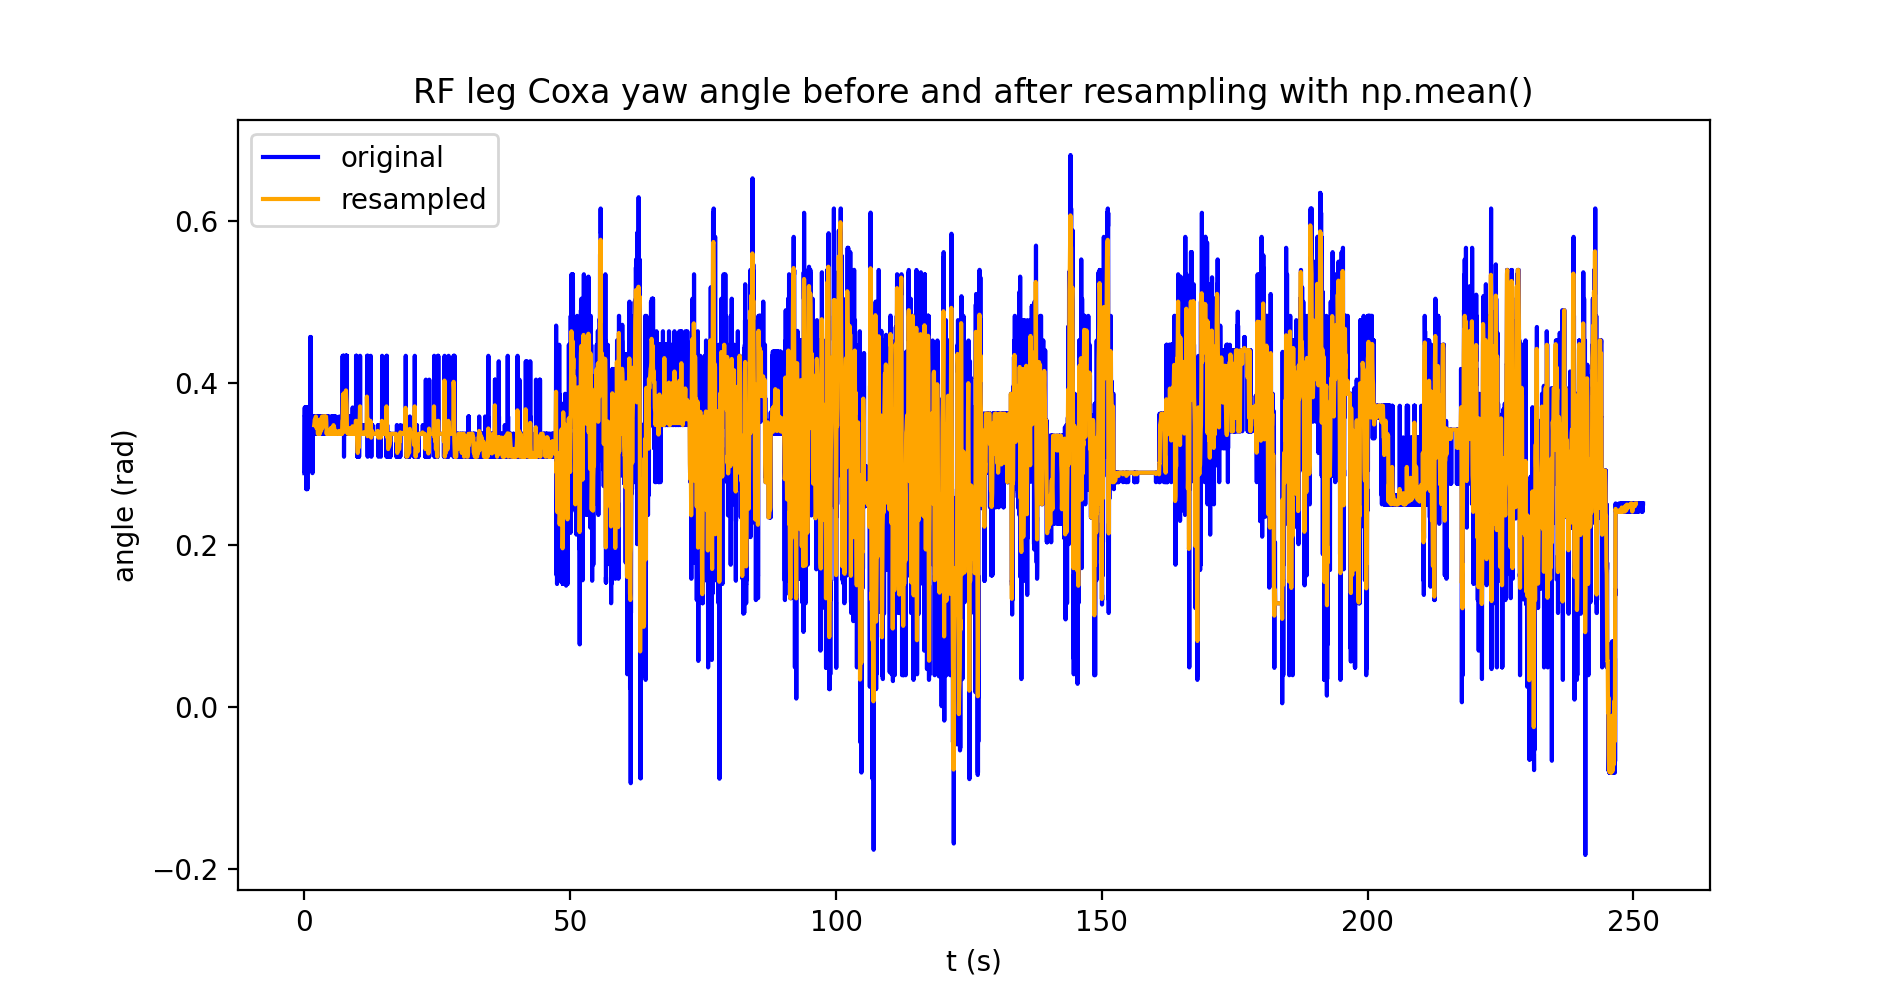

Text(0.5, 1.0, 'RF leg Coxa yaw angle before and after resampling with np.mean()')

In [8]:
%matplotlib notebook

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 5), sharex=True, sharey=True)
ax.plot(beh_df.loc[(210301, "J1xCI9", 1, 0), "t"], values, 'blue', label="original")
ax.plot(neural_df.loc[(210301, "J1xCI9", 1, 0), "t"], reduced, 'orange', label="resampled")
ax.set_xlabel("t (s)")
ax.set_ylabel("angle (rad)")
ax.legend()
ax.set_title("RF leg Coxa yaw angle before and after resampling with np.mean()")

## try out the function for multiple variables at the same time, e.g. all angles on the RF leg

In [9]:
twop_index = beh_df.loc[(210301, "J1xCI9", 1, 0), "twop_index"].to_numpy()
# alternative: beh_df[beh_df.index.get_level_values("Trial")==0]["twop_index"].to_numpy()

In [10]:
values = beh_df.loc[(210301, "J1xCI9", 1, 0)].filter(regex="angle_RF_leg").to_numpy()

In [11]:
reduced = reduce_during_2p_frame(twop_index, values, function=reduce_mean)

<IPython.core.display.Javascript object>


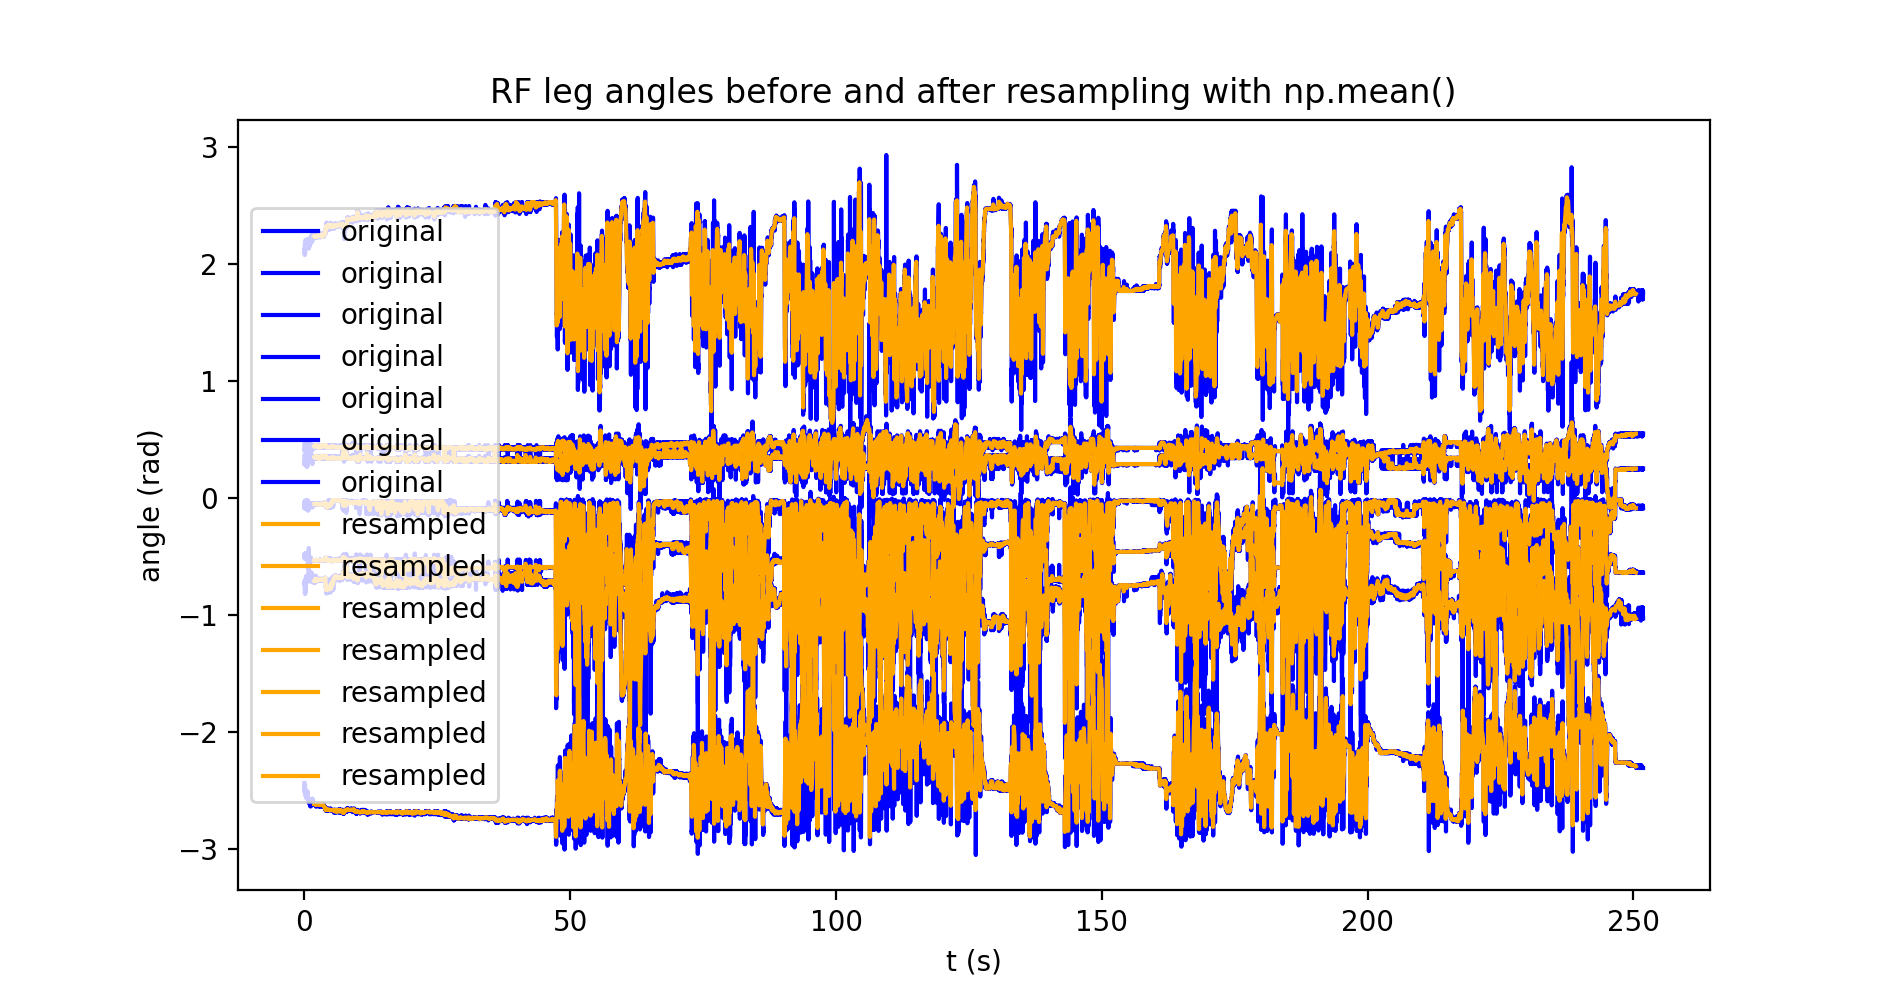

Text(0.5, 1.0, 'RF leg angles before and after resampling with np.mean()')

In [12]:
%matplotlib notebook

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 5), sharex=True, sharey=True)
ax.plot(beh_df.loc[(210301, "J1xCI9", 1, 0), "t"], values,'blue', label="original")
ax.plot(neural_df.loc[(210301, "J1xCI9", 1, 0), "t"], reduced, 'orange', label="resampled")
ax.set_xlabel("t (s)")
ax.set_ylabel("angle (rad)")
ax.legend()
ax.set_title("RF leg angles before and after resampling with np.mean()")

## P.S.: don't create plots where multiple lines have the same label, like in the one above